In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold # import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_selection import SelectFromModel

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import yellowbrick as yb

In [2]:
from EnergyScience.utilities import timeseries_train_test_split

### Predict Energy consumption

In [3]:
dataset = pd.read_csv('../data1/dataset_fairbanks.csv')

In [34]:
dataset.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Cooling:Electricity [kW](Hourly)',
       'Date/Time', 'Electricity:Facility [kW](Hourly)',
       'Fans:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'building_type',
       'location', 'location_id', 'building_id', 'Date', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Electricity:Facility [kW](Hourly)_lag',
       'Electricity:Facility [kW](Hourly)_future',
       'Electricity:Facility_delta_current_lag', 'Christmas Day',
       'Columbus Day', 'Independence Day', 'Labor Day',
       'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day

In [14]:
dataset_numeric = dataset[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'location_id', 'building_id', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_AK_FAIRBANKS']]

data = dataset[['Cooling:Electricity [kW](Hourly)',
                'Electricity:Facility [kW](Hourly)',
                'Fans:Electricity [kW](Hourly)',
                'Gas:Facility [kW](Hourly)',
                'InteriorEquipment:Electricity [kW](Hourly)',
                'InteriorLights:Electricity [kW](Hourly)',
                'RefBldgLargeHotelNew',
                'temperatureHigh',
                'Electricity:Facility [kW](Hourly)_lag',
                'Electricity:Facility_delta_current_lag',
                'Electricity:Facility [kW](Hourly)_future']]
                           
                            

In [4]:
dataset_numeric.describe()

,Cooling:Electricity [kW](Hourly),Electricity:Facility [kW](Hourly),Electricity:Facility [kW](Hourly)_lag,Electricity:Facility [kW](Hourly)_future,Electricity:Facility_delta_current_lag,Fans:Electricity [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),...,RefBldgPrimarySchoolNew,RefBldgQuickServiceRestaurantNew,RefBldgSecondarySchoolNew,RefBldgSmallHotelNew,RefBldgSmallOfficeNew,RefBldgStand-aloneRetailNew,RefBldgStripMallNew,RefBldgSuperMarketNew,RefBldgWarehouseNew,USA_AK_FAIRBANKS
count,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,...,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.000000,140112.0
mean,24.466694,169.689976,169.579505,169.669213,0.110471,16.928109,165.746308,2.157866,128.502618,53.220947,...,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062350,1.0
std,75.401988,262.199002,262.125849,262.204330,358.316614,25.783758,308.852186,10.706781,281.554114,83.215305,...,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.242101,0.241791,0.0
min,0.000000,1.925019,1.925019,1.925019,-1285.984141,0.000000,0.000000,0.000000,0.000000,1.011600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,23.209451,23.114820,23.167954,-85.253925,1.049215,6.090957,0.000000,0.000000,8.092797,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,57.602953,57.593582,57.593582,14.543872,4.732657,54.170976,0.000000,31.947620,20.643869,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,2.082836,188.634591,188.416402,188.573973,95.141824,27.108462,154.212569,0.000000,111.177658,53.238744,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,404.825226,1401.378033,1401.378033,1401.378033,1263.326353,117.252946,4491.695087,288.845279,4480.732902,448.566544,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [14]:
corr_matrix = dataset_numeric.corr()
corr_matrix["Electricity:Facility [kW](Hourly)_future"].sort_values(ascending=False)

Electricity:Facility [kW](Hourly)_future      1.000000
RefBldgLargeHotelNew                          0.724142
Water Heater:WaterSystems:Gas [kW](Hourly)    0.651091
RefBldgMediumOfficeNew                        0.404724
InteriorEquipment:Gas [kW](Hourly)            0.276871
Electricity:Facility [kW](Hourly)_lag         0.250173
Heating:Electricity [kW](Hourly)              0.219368
Gas:Facility [kW](Hourly)                     0.156201
InteriorEquipment:Electricity [kW](Hourly)    0.098277
RefBldgLargeOfficeNew                         0.077453
RefBldgSmallHotelNew                          0.067109
Electricity:Facility [kW](Hourly)             0.065775
InteriorLights:Electricity [kW](Hourly)       0.064191
Cooling:Electricity [kW](Hourly)              0.038464
is_weekend                                    0.036488
Monday                                        0.027141
Sunday                                        0.025770
Tuesday                                       0.025544
Saturday  

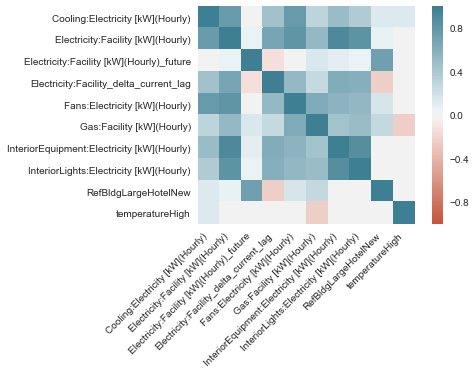

In [9]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

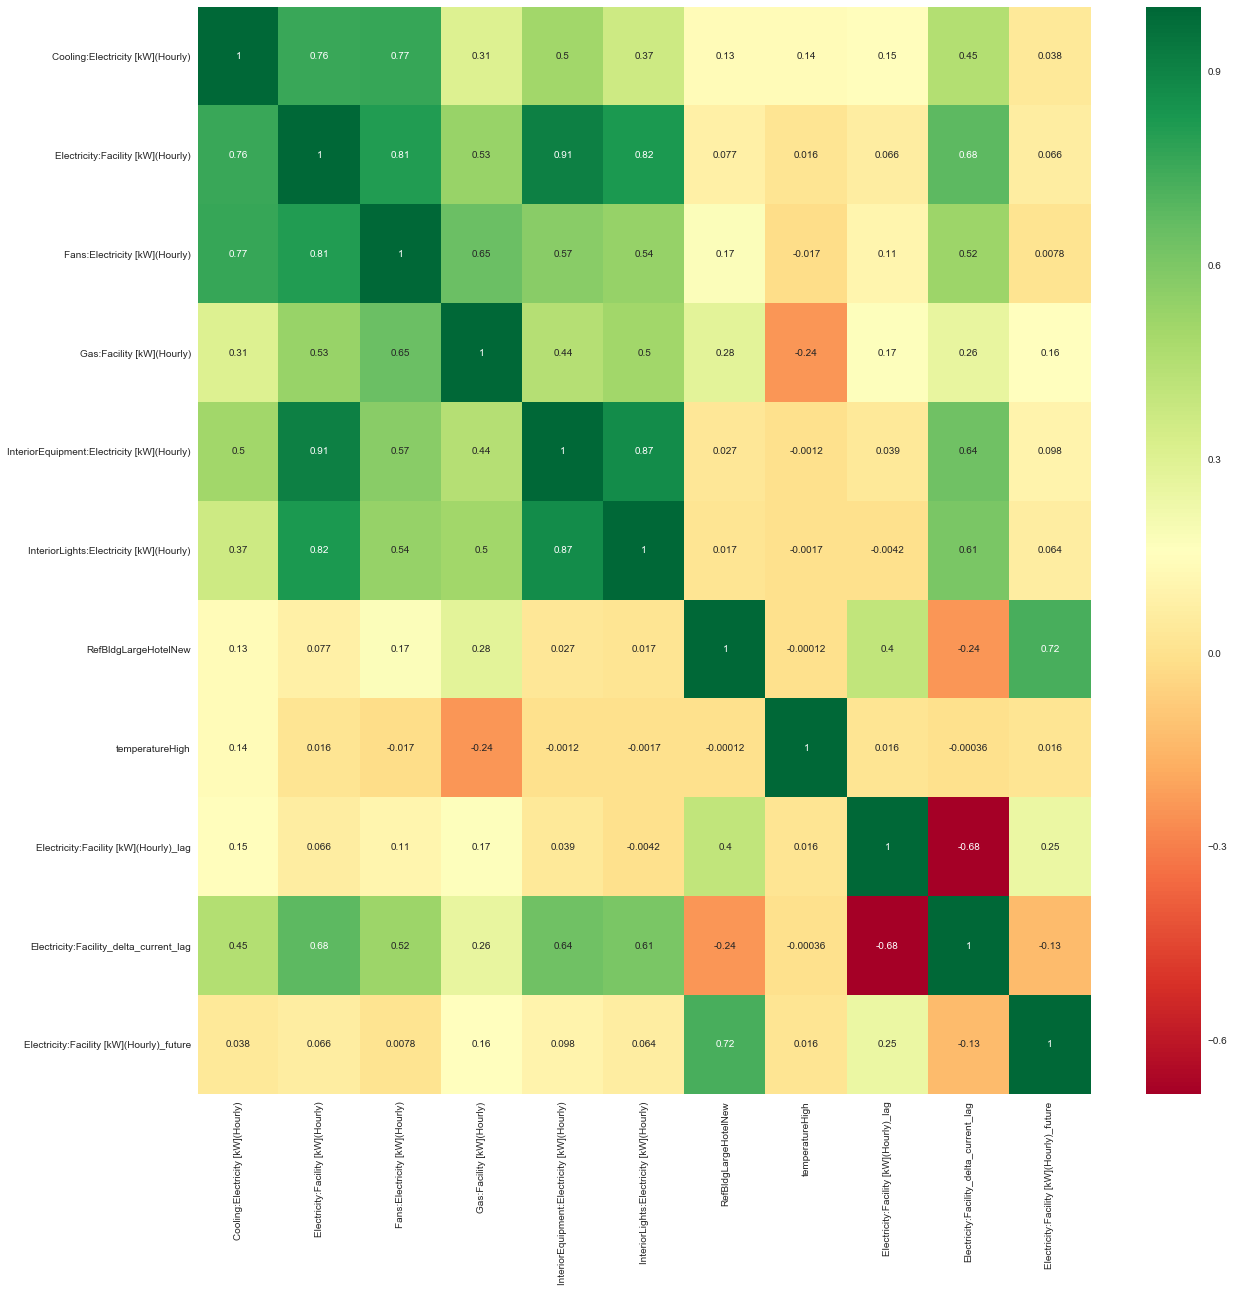

In [15]:
X = data.iloc[:,0:9]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [15]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
dataset_numeric_scaling = dataset_numeric[['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover']]
scaled_df = scaler.fit_transform(dataset_numeric_scaling)
scaled_df = pd.DataFrame(scaled_df, columns=['Cooling:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility [kW](Hourly)_future',
                           'Electricity:Facility_delta_current_lag',
                           'Fans:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                           'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
                           'InteriorEquipment:Electricity [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'InteriorLights:Electricity [kW](Hourly)',
                           'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
                            'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover'])

one_hot_encoded_data = dataset_numeric[['Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday', 'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_AK_FAIRBANKS']]

In [16]:
processed_data = pd.concat((scaled_df, one_hot_encoded_data), axis=1)

In [17]:
processed_data.columns

Index(['Cooling:Electricity [kW](Hourly)', 'Electricity:Facility [kW](Hourly)',
       'Electricity:Facility [kW](Hourly)_lag',
       'Electricity:Facility [kW](Hourly)_future',
       'Electricity:Facility_delta_current_lag',
       'Fans:Electricity [kW](Hourly)', 'Gas:Facility [kW](Hourly)',
       'Heating:Electricity [kW](Hourly)', 'Heating:Gas [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)',
       'InteriorEquipment:Gas [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'Water Heater:WaterSystems:Gas [kW](Hourly)', 'time', 'sunriseTime',
       'sunsetTime', 'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
       'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
       'Presidents Day', 'Thanksgiving', 'Veterans Day', 'is_weekend',
       'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', '

In [29]:
dataset_features = processed_data[['Cooling:Electricity [kW](Hourly)',
                           'Gas:Facility [kW](Hourly)',
                            'InteriorEquipment:Electricity [kW](Hourly)',
                            'Fans:Electricity [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)',
                           'Electricity:Facility [kW](Hourly)_lag',
                           'Electricity:Facility_delta_current_lag',
                           'Heating:Electricity [kW](Hourly)',
                            'Water Heater:WaterSystems:Gas [kW](Hourly)',
                           'InteriorEquipment:Gas [kW](Hourly)',
                           'temperatureHigh', 'dewPoint', 'humidity', 'windSpeed',
                           'cloudCover', 'Christmas Day', 'Columbus Day', 'Independence Day',
                           'Labor Day', 'Martin Luther King Day', 'Memorial Day', 'New Years Day',
                           'Presidents Day', 'Thanksgiving', 'Veterans Day','is_weekend',
                           'is_holiday', 'Friday', 'Monday', 'Saturday', 'Sunday',
                           'Thursday', 'Tuesday', 'Wednesday',
                           'RefBldgFullServiceRestaurantNew',
       'RefBldgHospitalNew', 'RefBldgLargeHotelNew', 'RefBldgLargeOfficeNew',
       'RefBldgMediumOfficeNew', 'RefBldgMidriseApartmentNew',
       'RefBldgOutPatientNew', 'RefBldgPrimarySchoolNew',
       'RefBldgQuickServiceRestaurantNew', 'RefBldgSecondarySchoolNew',
       'RefBldgSmallHotelNew', 'RefBldgSmallOfficeNew',
       'RefBldgStand-aloneRetailNew', 'RefBldgStripMallNew',
       'RefBldgSuperMarketNew', 'RefBldgWarehouseNew',
       'USA_AK_FAIRBANKS',
        'time', 'sunriseTime', 'sunsetTime']]

dataset_labels = processed_data['Electricity:Facility [kW](Hourly)_future']

In [30]:
#X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.2)
X_train, X_test, y_train, y_test = timeseries_train_test_split(dataset_features, dataset_labels, test_size=0.2)

Linear Regression model
Mean Squared Error: 0.447
Coefficient of Determination: 0.548
Coefficients: [ 1.05937443e-01 -8.12106591e-03  4.10897813e-01 -1.66066850e-01
  2.42367440e+11 -2.42299820e+11 -3.31215145e+11  2.69567436e-01
  6.78572220e-01  1.57852457e-01  9.43831481e-02 -7.97180022e-02
  2.06241782e-02  4.16925383e-03  6.97145944e-03 -1.74111433e-01
  7.63036541e-03 -2.69924513e-01  2.65768553e-02  6.61048659e-02
 -6.19478935e-02 -5.91837392e-02  5.69352909e-03  4.42559050e-02
  1.13809701e-02  1.15293618e+11  1.07170456e-02  9.76249159e+10
  9.76249159e+10 -1.76687022e+10 -1.76687022e+10  9.76249159e+10
  9.76249159e+10  9.76249159e+10  0.00000000e+00 -1.02725606e+02
  3.89473604e+01  6.37897028e+01]


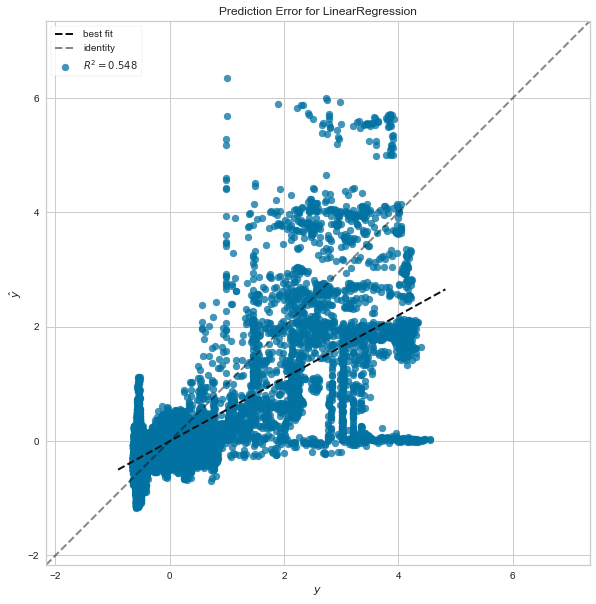

In [20]:
X_train, X_test, y_train, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.2)
from yellowbrick.regressor import PredictionError
model = LinearRegression(normalize=True)
est = model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Linear Regression model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
print('Coefficients: {}'.format(model.coef_))
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Ridge model
Mean Squared Error: 0.448
Coefficient of Determination: 0.547


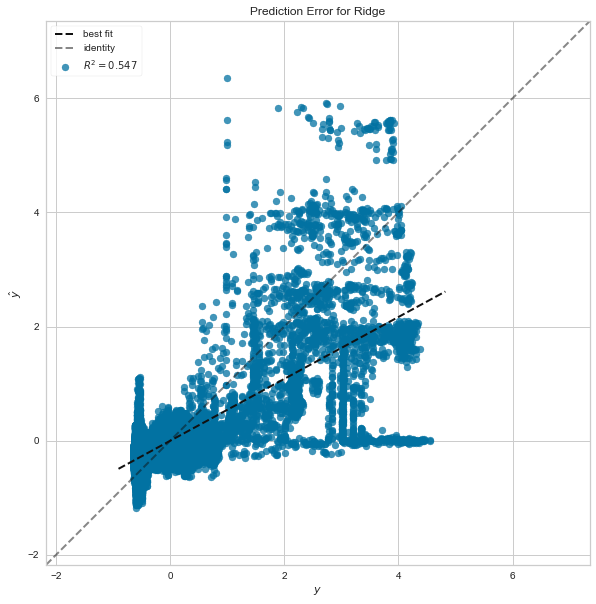

In [21]:
# X_train, X_test, y_train, y_test = timeseries_train_test_split(dataset_features, dataset_labels, test_size=0.2)
ridge = Ridge(alpha=1000)
ridge.fit(X_train, y_train)

expected = y_test
predicted = ridge.predict(X_test)

print('Ridge model')
print('Mean Squared Error: %0.3f' % mse(expected, predicted))
print('Coefficient of Determination: %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(ridge, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()         

Ridge model
Mean squared error = 0.447
R2 score = 0.548


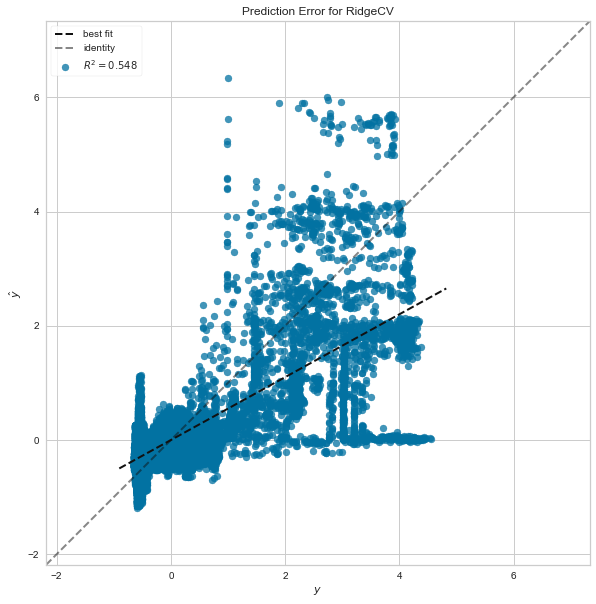

In [22]:
regr_cv = RidgeCV(alphas=[0.5, 100, 1000])
regr_cv.fit(X_train, y_train)

expected = y_test
predicted = regr_cv.predict(X_test)

print('Ridge model')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(regr_cv, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()

In [23]:
regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)
regr_trans.fit(X_train, y_train)
expected = y_test
predicted = regr_trans.predict(X_test)

print('Transformed target regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Transformed target regressor
Mean squared error = 1.594
R2 score = -0.612


Gradient boosting regressor
Mean squared error = 0.230
R2 score = 0.768


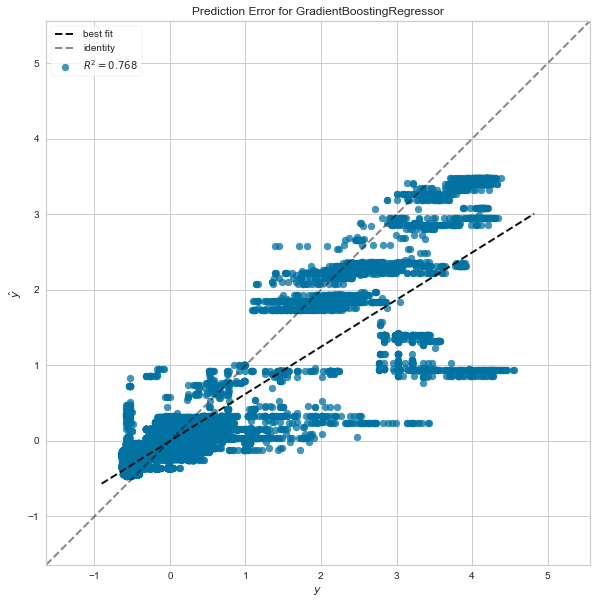

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.05)
gb.fit(X_train,y_train)
expected = y_test
predicted = gb.predict(X_test)

print('Gradient boosting regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(gb, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Lasso
Mean squared error = 0.590
R2 score = 0.404


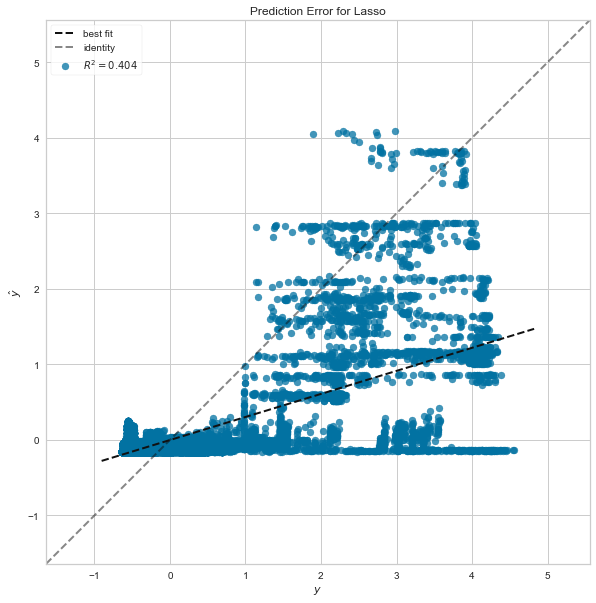

In [25]:
lasso = Lasso(alpha=0.2, max_iter=10e5)
lasso.fit(X_train,y_train)
expected = y_test
predicted = lasso.predict(X_test)

print('Lasso')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(lasso, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [26]:
elastic = ElasticNet(alpha=0.15, max_iter=10e5)
elastic.fit(X_train,y_train)
expected = y_test
predicted = elastic.predict(X_test)

print('Elastic')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))

Elastic
Mean squared error = 0.517
R2 score = 0.478


knn
Mean squared error = 0.067
R2 score = 0.934


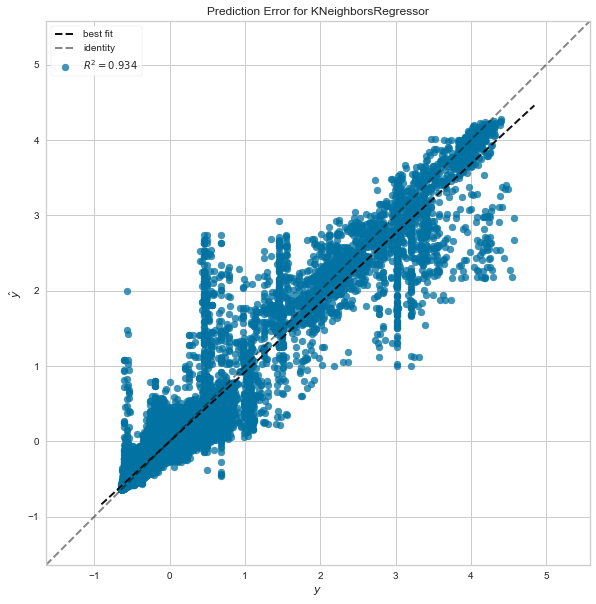

In [63]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=15)
knn.fit(X_train,y_train)
expected = y_test
predicted = knn.predict(X_test)

print('knn')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(knn, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Random Forest Regressor
Mean squared error = 0.312
R2 score = 0.685


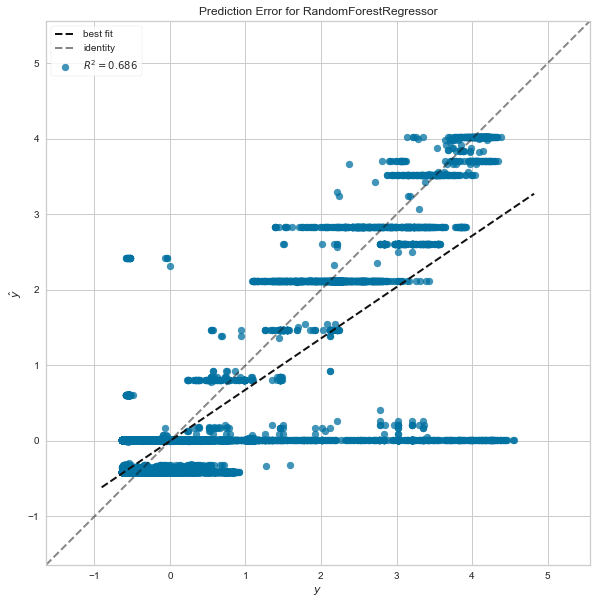

In [28]:
random_forest = RandomForestRegressor(n_estimators=50, max_depth=3)
random_forest.fit(X_train,y_train)
expected = y_test
predicted = random_forest.predict(X_test)

print('Random Forest Regressor')
print('Mean squared error = %0.3f' % mse(expected, predicted))
print('R2 score = %0.3f' % r2_score(expected, predicted))
visualizer = PredictionError(random_forest, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

## Feature Analysis and Selection

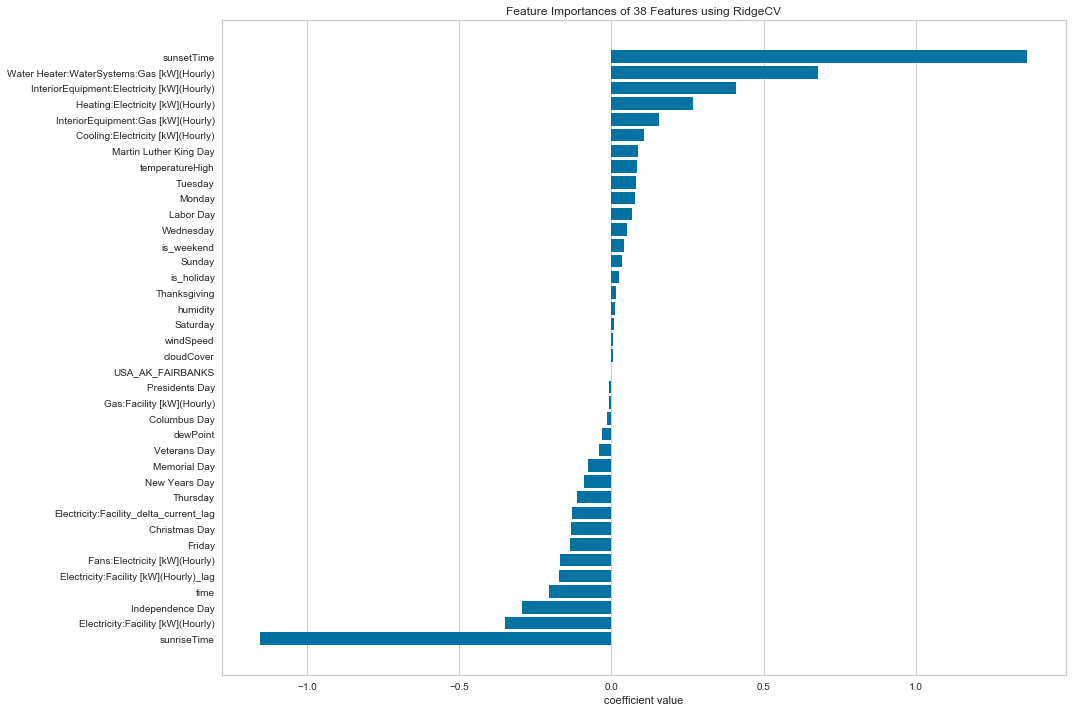

In [27]:
from yellowbrick.features import FeatureImportances

# model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(regr_cv, size=(1080, 720), relative=False)

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

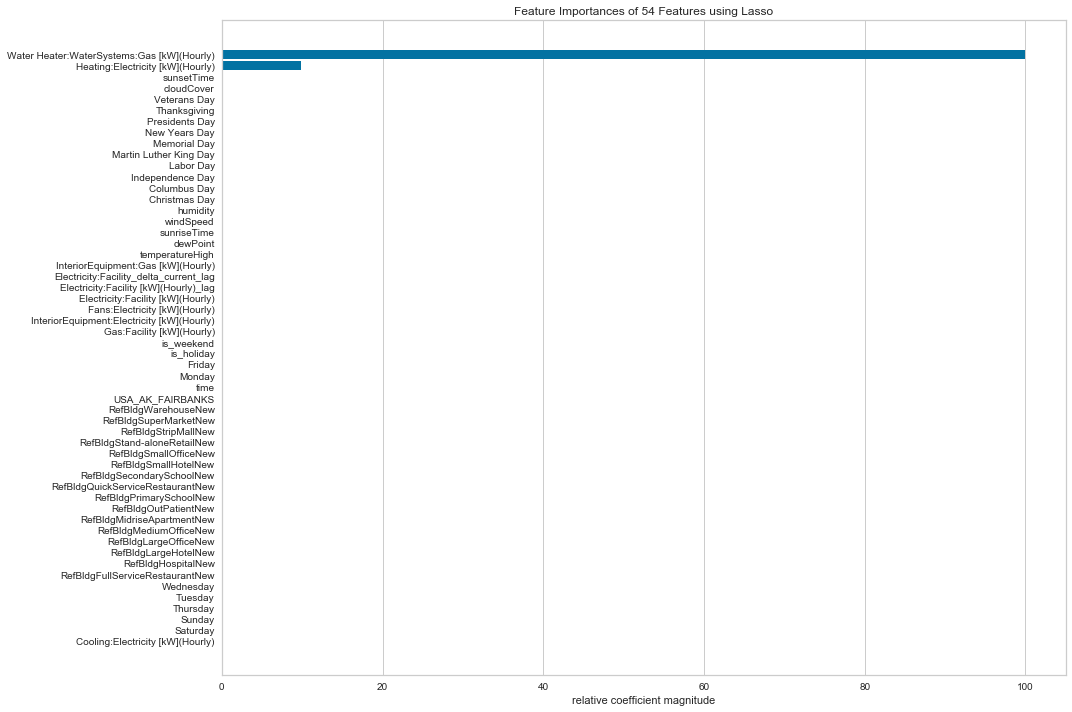

In [53]:
viz = FeatureImportances(lasso, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

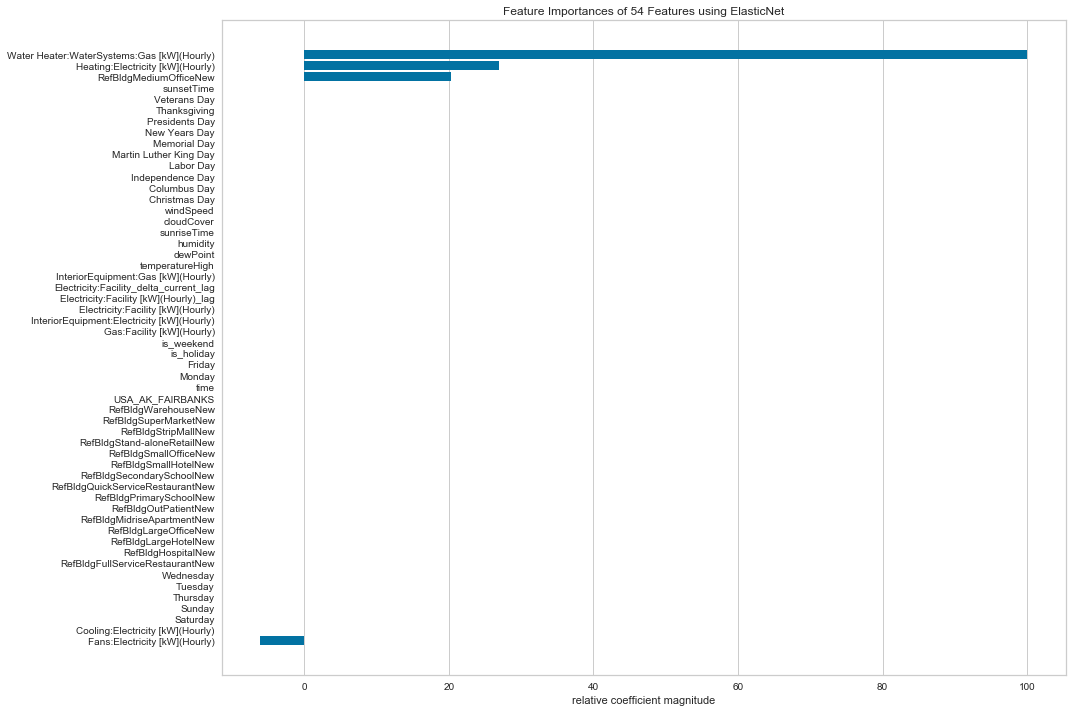

In [54]:
viz = FeatureImportances(elastic, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

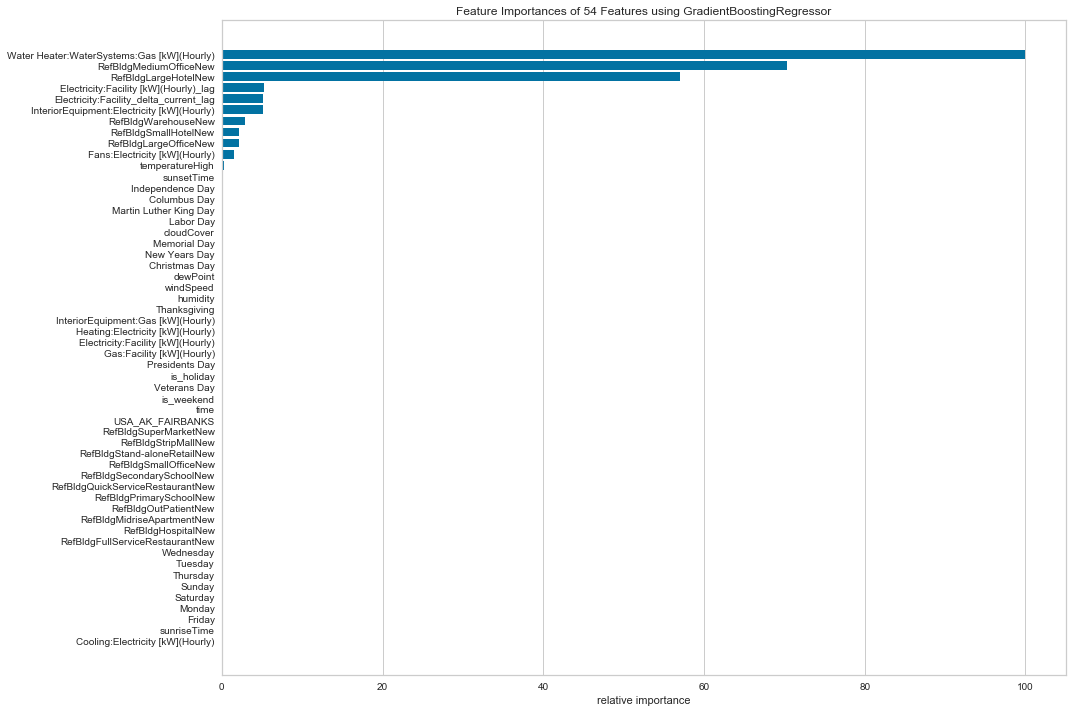

In [55]:
viz = FeatureImportances(gb, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

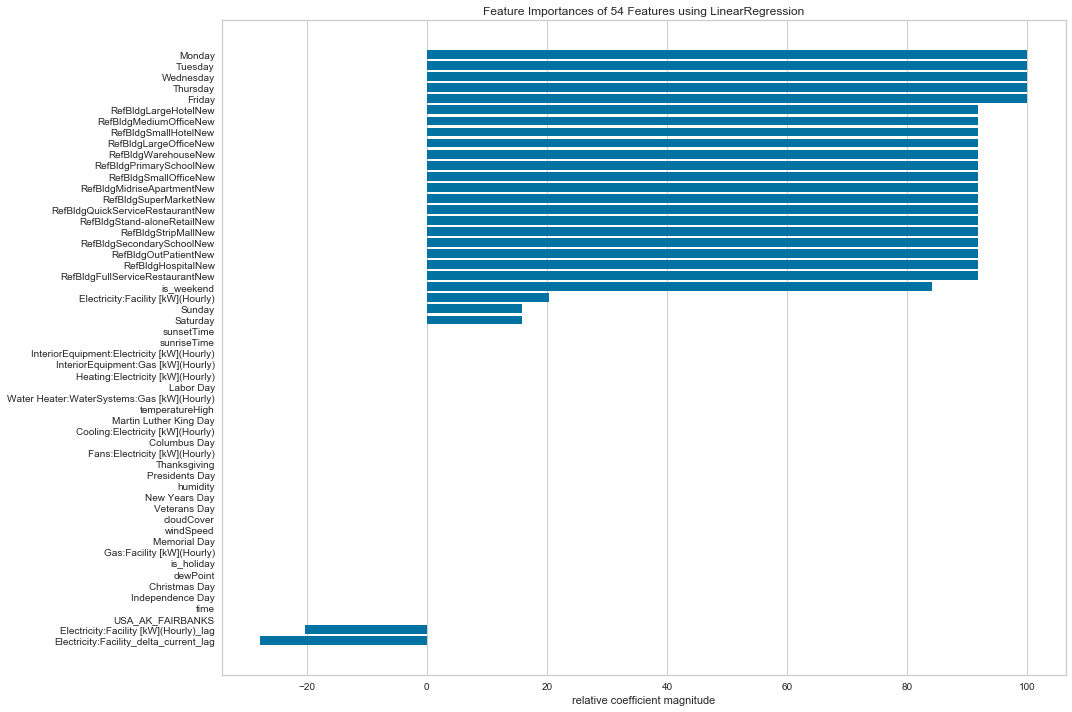

In [56]:
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

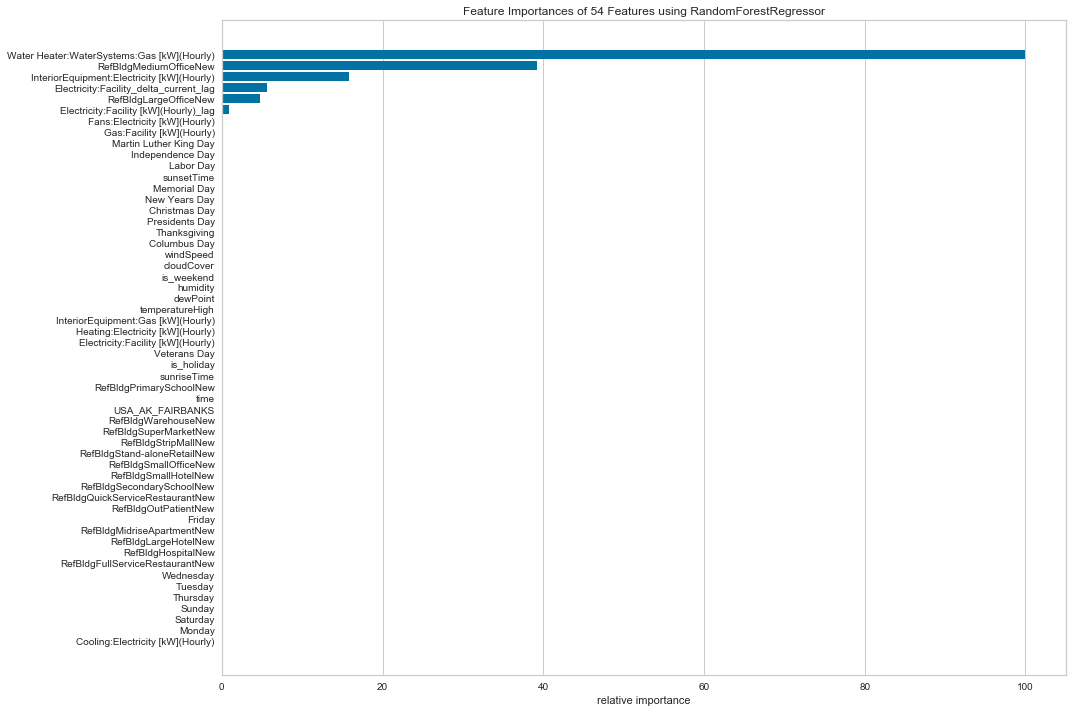

In [57]:
viz = FeatureImportances(random_forest, size=(1080, 720))

viz.fit(dataset_features, dataset_labels)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

## Residual plots

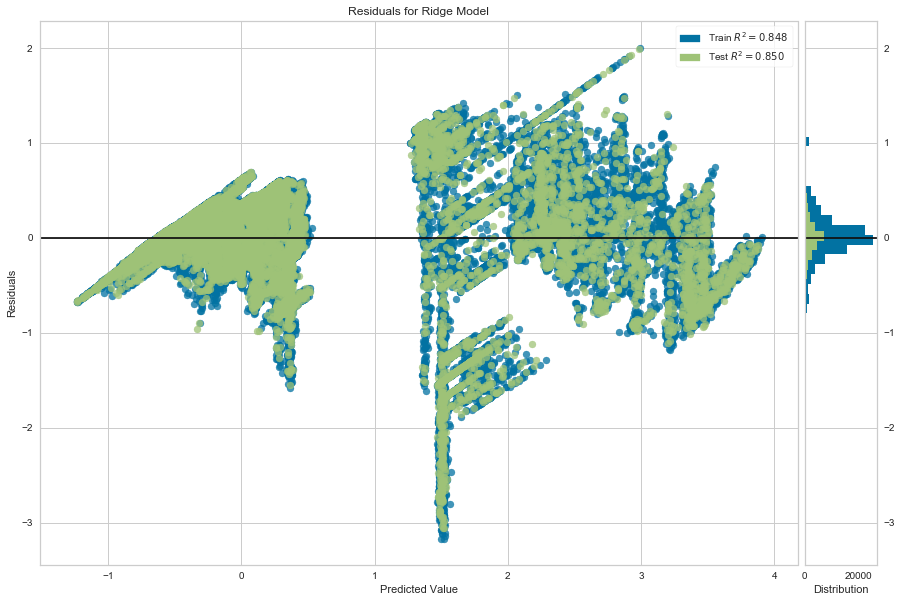

In [58]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

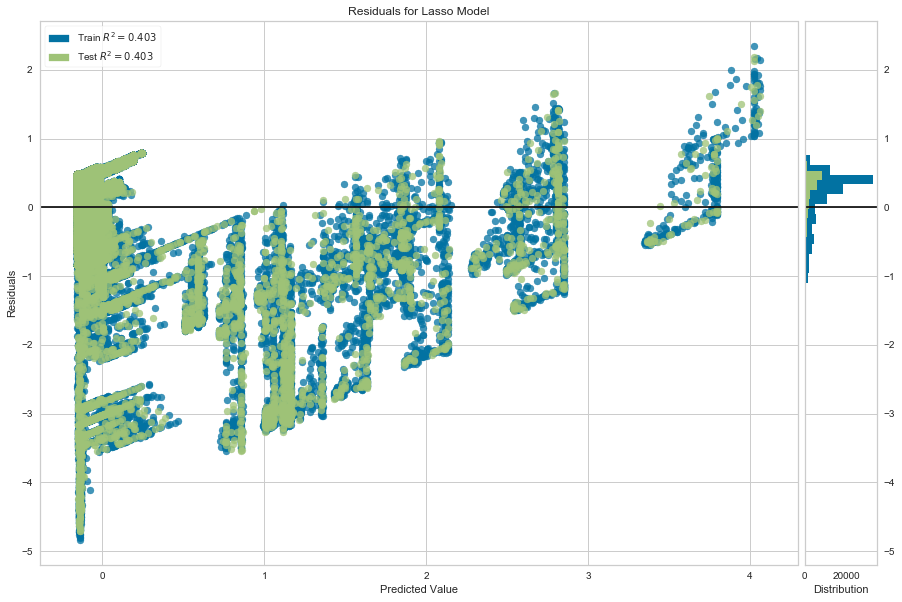

In [59]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = Lasso(alpha=0.2, max_iter=10e5)
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

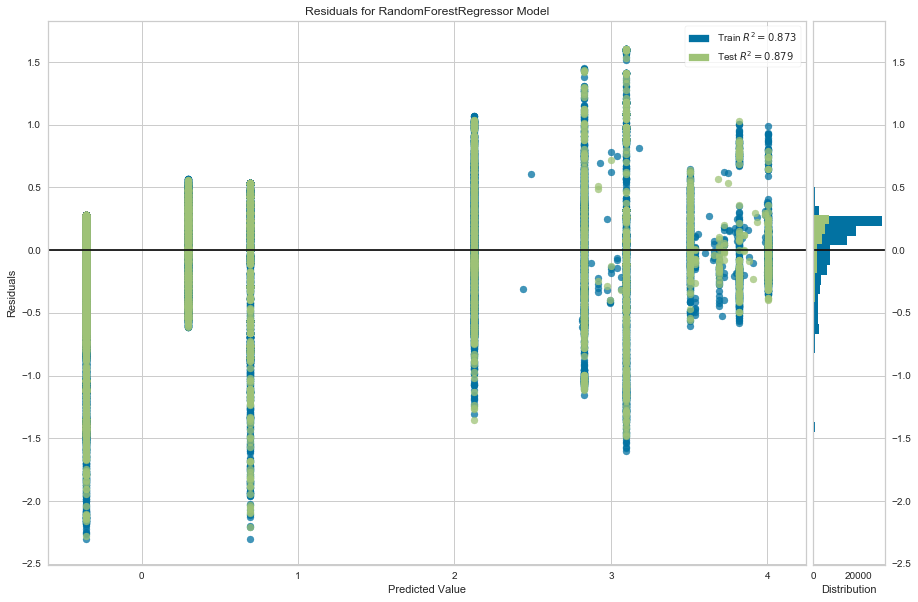

In [60]:
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = RandomForestRegressor(n_estimators=50, max_depth=3)
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

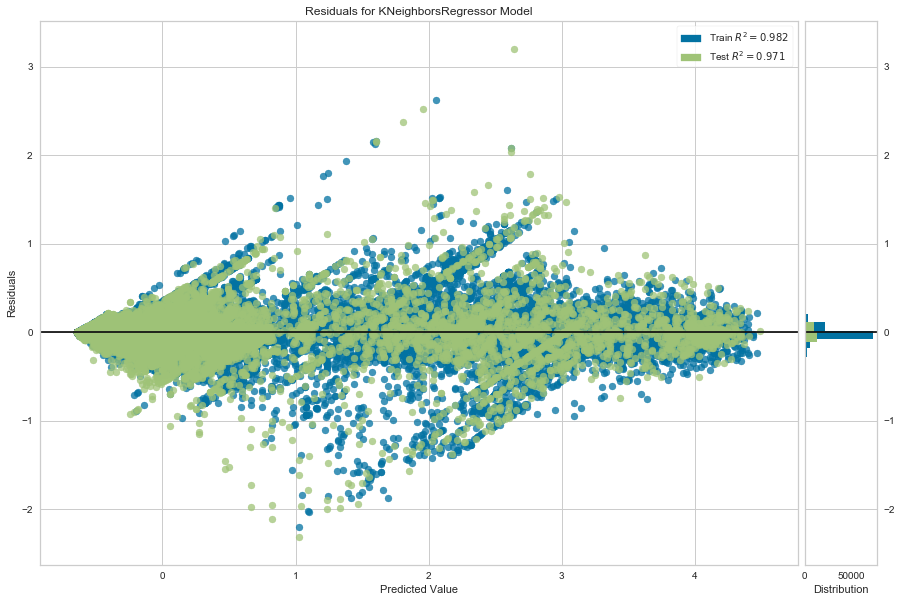

In [61]:
from sklearn.neighbors import KNeighborsRegressor

from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = KNeighborsRegressor()
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

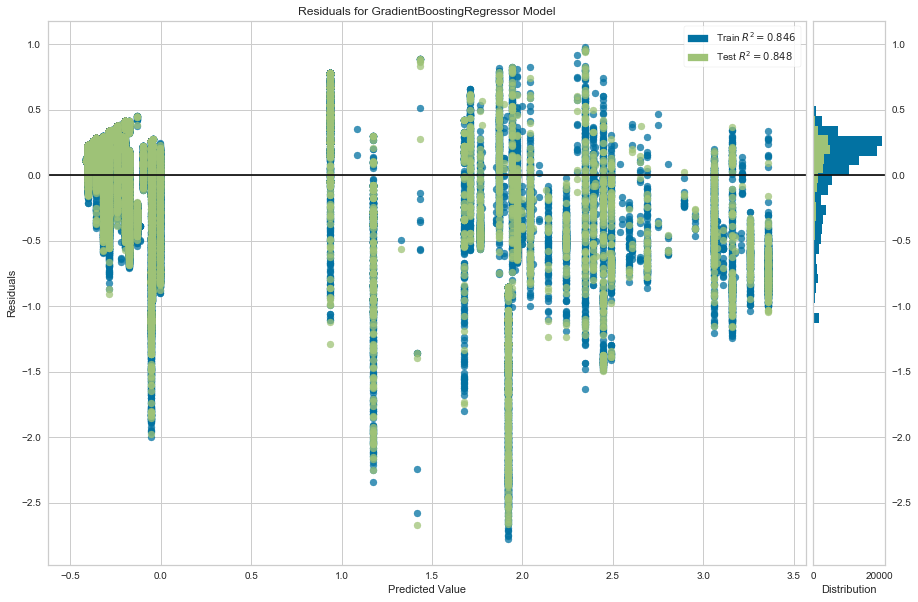

In [62]:
from sklearn.ensemble import GradientBoostingRegressor

from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
gb = GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.05)
visualizer = ResidualsPlot(gb, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data